In [1]:
import scipy
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from tqdm import tqdm
import librosa
import sklearn
from sklearn.manifold import TSNE 
from sklearn.cluster import Birch, KMeans
from sklearn.metrics import rand_score, adjusted_rand_score, ConfusionMatrixDisplay
from sklearn_extra.cluster import CLARA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import multiprocessing
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import torch

/home/visan/miniconda3/envs/pml-project2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the wav2vec model

Here we load the meta's wav2vec base model that was not fine tuned on labeled data.

In [2]:
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")  
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/home/visan/miniconda3/envs/pml-project2/lib/python3.13/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [3]:
class AudioFile:
    def __init__(self, sample_rate, samples):
        self.sample_rate = sample_rate
        self.samples = samples

### Loading the datset

Here we load the audio dataset. It is composed of 60 folders, one for each speaker. In each speaker folder there are 50 audio files for each digit.

Our dataset will be stored in a python dictionary so that we can index it like this:


```python
audio_files_for_digit_8 = dataset[Speaker][8]
```

We also downsample each audio file to 16KHz to be compatible with the wav2vec model.

In [19]:
def load_digits(path):
    digits = dict()

    for digit in range(10):
        filenames = glob.glob(f"{digit}_*_*.wav", root_dir=path)
        audio_files = []

        for filename in filenames:
            sample_rate, samples = wavfile.read(os.path.join(path, filename))

            # Here we resample the signal to 16KHZ because the wav2vec model only supports this.
            samples = librosa.resample(y=np.astype(samples, np.double), orig_sr=sample_rate, target_sr=16000)

            audio_files.append(AudioFile(16000, samples))

        digits[digit] = audio_files

    return digits 

def load_dataset(path):
    dirs = next(os.walk(path))[1]
    print(f"The number of speakers is: {len(dirs)}")

    dataset = dict()

    for speaker in tqdm(dirs):
        dataset[speaker] = load_digits(os.path.join(path, speaker)) 
        
    return dataset
    
dataset = load_dataset("data")

The number of speakers is: 60


100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


### Dataset analysis

Here we make sure that all files have the same sample rate. We also plot the histogram for the number of samples in each file.

The sample rates are: {16000}. There should be only one sample rate.
The maximum amount of samples is:  16000


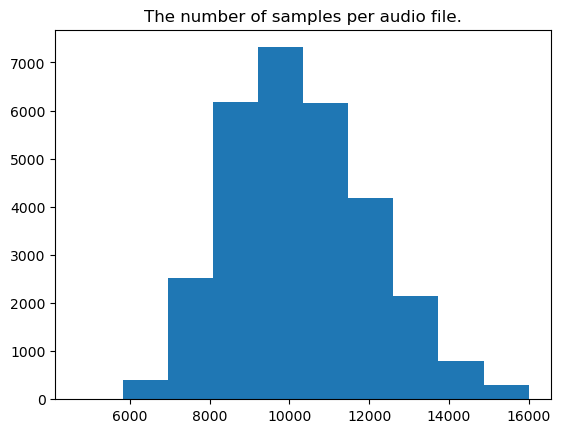

In [20]:
# Here we make sure that all files have the same sample rate.
sample_rates = set()

# We want to plot a histogram of the number of samples in the audio files.
num_samples = [] 

for speaker in dataset:
    for digit in range(10):
        for file in dataset[speaker][digit]:
            sample_rates.add(file.sample_rate)
            num_samples.append(len(file.samples))

max_samples = max(num_samples)
print(f"The sample rates are: {sample_rates}. There should be only one sample rate.")
print("The maximum amount of samples is: ", max(num_samples))
plt.title("The number of samples per audio file.")
plt.hist(num_samples)
plt.show()

### Feature extraction

We pass each signal through the wav2vec model and get the embeddings. The embeddings are taken from the last convolutional layer of the model.

In [6]:
def extract_features(signal):
    input_values = feature_extractor(signal, sampling_rate=16000, return_tensors="pt").input_values

    with torch.no_grad():
        features = wav2vec_model(input_values).extract_features
        # Average pool over the temporal dimension
        features = torch.mean(features, dim=1)

    return features.squeeze()

In [7]:
X = []
y = []

for speaker in tqdm(dataset):
    for digit in range(0, 10):
        for audio_file in dataset[speaker][digit]:
            X.append(extract_features(audio_file.samples))
            y.append(digit)

X = np.array(X)
y = np.array(y)

100%|██████████| 60/60 [1:00:27<00:00, 60.45s/it]


### Saving the features to a file.

The feature extraction part takes a long time ~1 hour because we don't use batching. We opted out of using batching
because padding with zeroes affects the embeddings in a negative way (lower clustering performance). 

In [8]:
torch.save(X, "wav2vec-features.pt")
torch.save(y, "wav2vec-labels.pt")

### Loading the features from the file

Use this code block instead of recomputing the features.

In [22]:
X = torch.load("wav2vec-features.pt")
y = torch.load("wav2vec-labels.pt")

/tmp/ipykernel_11799/715109643.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load("wav2vec-features.pt")
/tmp/ipykernel_11799/715109643.py:2: FutureWarning: 

### Train-test split

Here we split the dataset into train and test sets.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20100, 512) (20100,)
(9900, 512) (9900,)


### Training set visualization

We visualize the training set using T-SNE.

(20100, 2)


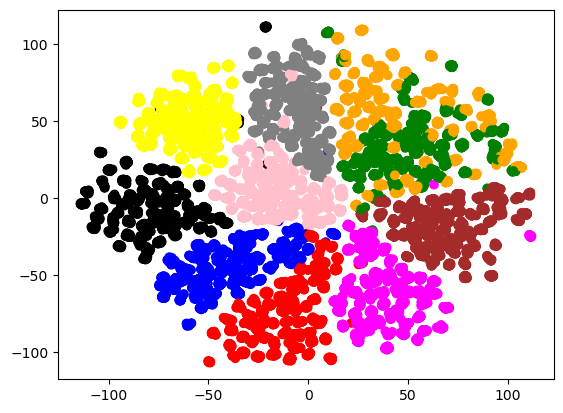

In [24]:
colors = np.array(["red", "green", "blue", "pink", "magenta", "brown", "yellow", "black", "grey", "orange"])

tsne = TSNE(n_components=2)
X_train_transform = tsne.fit_transform(X_train)

print(X_train_transform.shape)
plt.scatter(X_train_transform[:, 0], X_train_transform[:, 1], c=colors[y_train])

### Evaluating models

This function computes various metrics to evaluate the clustering performance. Most importantly, it finds a mapping from the cluster labels to the true labels using the Hungarian algorithm. This is useful because we 
can later report the true accuracy on the test set.

In [25]:
def evaluate_model(model, verbose=False):
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    contingency = contingency_matrix(y_train, predictions_train)

    if verbose:
        print("Rand score on the train set: ", rand_score(y_train, predictions_train))
        print("Adjusted rand score on the train set: ", adjusted_rand_score(y_train, predictions_train))

        print("Rand score on the test set: ", rand_score(y_test, predictions_test))
        print("Adjusted rand score on the test set: ", adjusted_rand_score(y_test, predictions_test))

        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
        axs[0].set_title("True labels")
        axs[0].scatter(X_train_transform[:, 0], X_train_transform[:, 1], c=colors[y_train])
        axs[1].set_title("Predicted - before alignment")
        axs[1].scatter(X_train_transform[:, 0], X_train_transform[:, 1], c=colors[predictions_train])

        plt.show()

        print("Contingency matrix:")
        disp = ConfusionMatrixDisplay(contingency)
        disp.plot()
        plt.show()


    # Compute the best assignment.
    rows, cols = linear_sum_assignment(contingency, maximize=True)
    
    # Now build the mapping.
    mapping = dict([])
    for index in range(len(rows)):
        mapping[int(cols[index])] = int(rows[index])

    updated_predictions_train = np.array(list(mapping[pred] for pred in predictions_train))
    updated_predictions_test= np.array(list(mapping[pred] for pred in predictions_test))

    train_accuracy = accuracy_score(y_train, updated_predictions_train)
    test_accuracy = accuracy_score(y_test, updated_predictions_test)

    if verbose:
        print("Best mapping using the hungarian algorithm: ", mapping)
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
        axs[0].set_title("True labels")
        axs[0].scatter(X_train_transform[:, 0], X_train_transform[:, 1], c=colors[y_train])
        axs[1].set_title("Predicted - after alignment")
        axs[1].scatter(X_train_transform[:, 0], X_train_transform[:, 1], c=colors[updated_predictions_train])
        plt.show()

        print("Accuracy of the model after the alignment on the train set: ", train_accuracy)
        print("Accuracy of the model after the alignment on the test set: ", test_accuracy)

    return (train_accuracy, test_accuracy)

### Finding the best Birch model

Here we fit multiple Birch clustering models with various hyperparameters.

In [26]:
models = [Birch(n_clusters=10, threshold=0.5, branching_factor=50)]

for model in models:
    model.fit(X_train, y_train)
    print(evaluate_model(model))


(0.7954726368159204, 0.7944444444444444)


In [16]:
clara = CLARA(n_clusters=10, n_sampling=5000, max_iter=600, metric="cosine")
clara.fit(X)

CLARA(max_iter=600, metric='cosine', n_clusters=10, n_sampling=5000)

Rand score on the train set:  0.9361341261254303
Adjusted rand score on the train set:  0.6534101720613089
Rand score on the test set:  0.933825843034854
Adjusted rand score on the test set:  0.6425544718148298


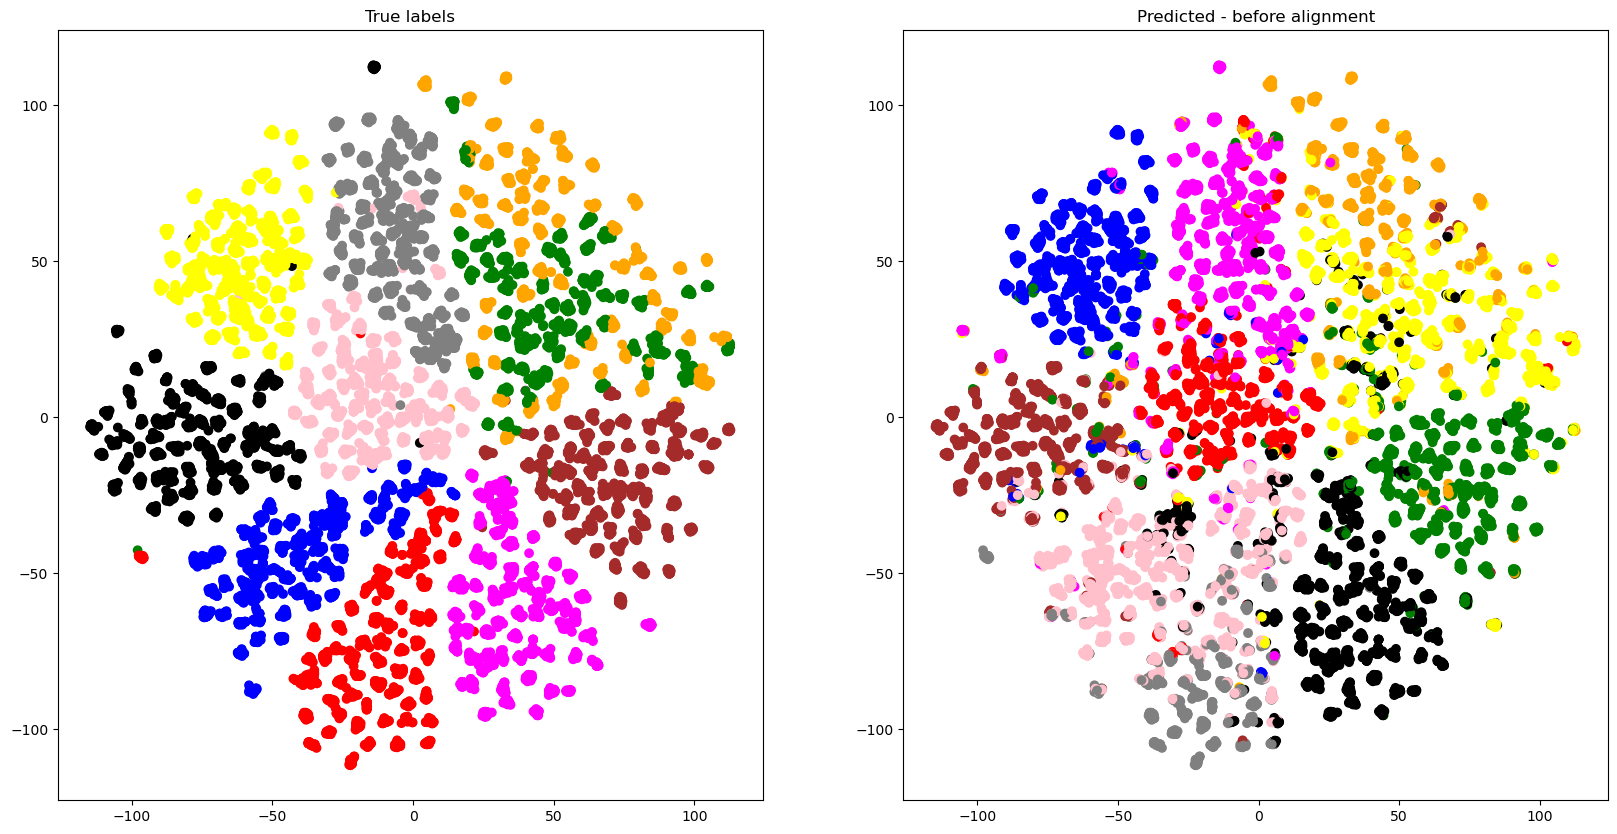

Contingency matrix:


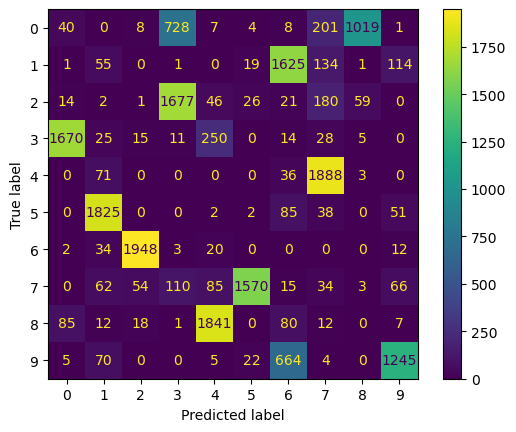

Best mapping using the hungarian algorithm:  {8: 0, 6: 1, 3: 2, 0: 3, 7: 4, 1: 5, 2: 6, 5: 7, 4: 8, 9: 9}


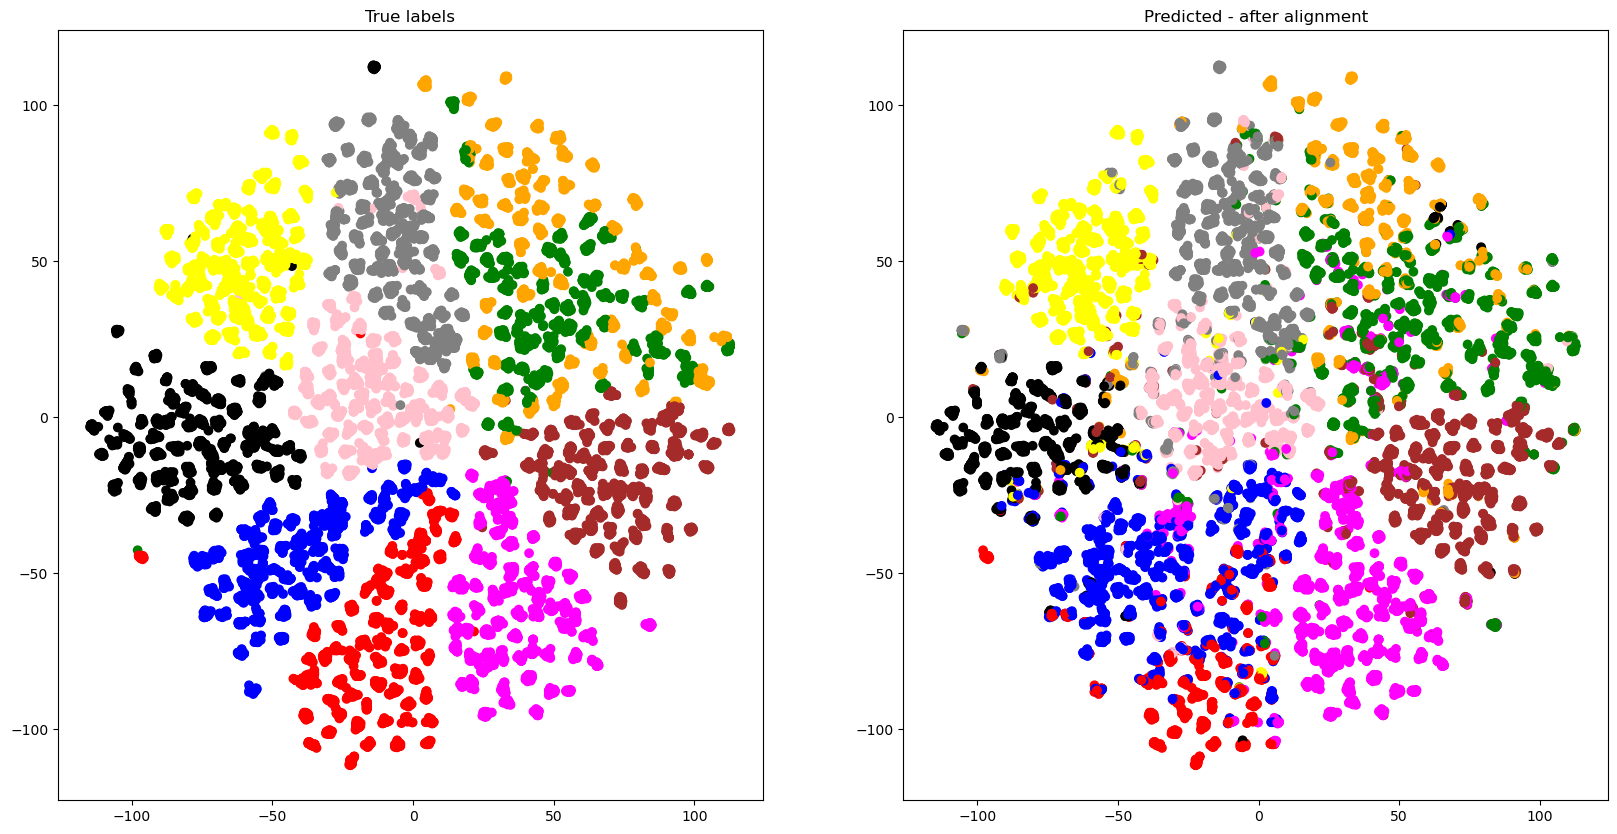

Accuracy of the model after the alignment on the train set:  0.8113432835820895
Accuracy of the model after the alignment on the test set:  0.8046464646464646


(0.8113432835820895, 0.8046464646464646)

In [17]:
evaluate_model(clara, verbose=True)